Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.053425 s

'compile' took 0.475652 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [3.56e-01, 3.16e-01, 0.00e+00, 1.00e+00]    [3.63e-01, 3.25e-01, 0.00e+00, 1.00e+00]    [1.28e+00]    
1000      [8.99e-03, 8.82e-03, 5.28e-08, 3.82e-04]    [1.02e-02, 8.74e-03, 5.28e-08, 3.82e-04]    [8.17e-01]    
2000      [7.54e-03, 5.26e-03, 1.00e-06, 6.98e-05]    [7.88e-03, 5.39e-03, 1.00e-06, 6.98e-05]    [6.68e-01]    
3000      [3.52e-03, 3.66e-03, 1.61e-06, 7.25e-05]    [3.67e-03, 3.76e-03, 1.61e-06, 7.25e-05]    [4.97e-01]    
4000      [1.12e-03, 1.75e-03, 1.70e-06, 3.06e-05]    [1.17e-03, 1.57e-03, 1.70e-06, 3.06e-05]    [2.75e-01]    
5000      [8.86e-04, 9.32e-04, 4.49e-04, 1.21e-04]    [9.35e-04, 8.40e-04, 4.49e-04, 1.21e-04]    [6.90e-02

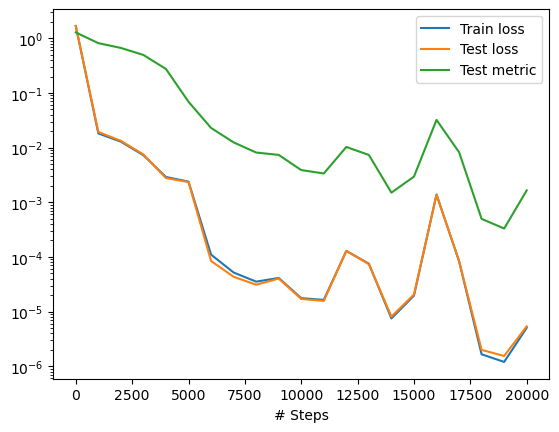

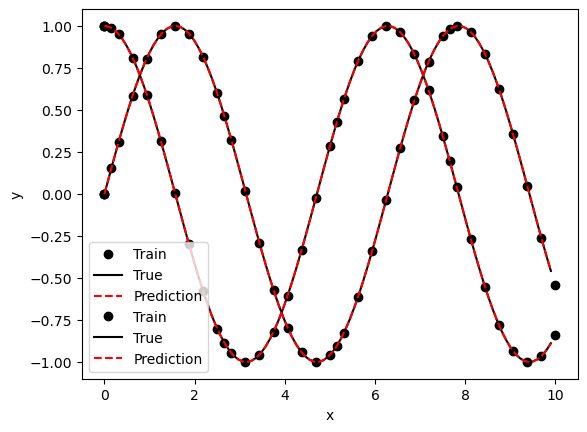

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    # Most backends
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    # Backend jax
    # y_val, y_fn = y
    # y1, y2 = y_val[:, 0:1], y_val[:, 1:]
    # dy1_x, _ = dde.grad.jacobian(y, x, i=0)
    # dy2_x, _ = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)